In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(1024)

In [8]:
seg_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\cellpose_slices_out")
seg_files = list(seg_path.glob("*201_downscaled_masks.tif"))
print(seg_files)
segs = [tifffile.imread(f) for f in seg_files]

[WindowsPath('D:/Tracking/NucleiTracking/data/interim/lightsheet/2024_11_04/cellpose_slices_out/img_ch0_ang021.8_time201_downscaled_masks.tif'), WindowsPath('D:/Tracking/NucleiTracking/data/interim/lightsheet/2024_11_04/cellpose_slices_out/img_ch0_ang111.9_time201_downscaled_masks.tif'), WindowsPath('D:/Tracking/NucleiTracking/data/interim/lightsheet/2024_11_04/cellpose_slices_out/img_ch0_ang201.9_time201_downscaled_masks.tif'), WindowsPath('D:/Tracking/NucleiTracking/data/interim/lightsheet/2024_11_04/cellpose_slices_out/img_ch0_ang291.8_time201_downscaled_masks.tif')]


In [9]:
from skimage.measure import regionprops_table
from cellpose.utils import stitch3D

masks = []

for i, seg in enumerate(segs):
    stitched = stitch3D(seg, 0.5)
    tifffile.imwrite(seg_files[i].parent / "stitched" / f"{seg_files[i].stem}_stitched.tif", stitched)
    masks.append(pd.DataFrame(regionprops_table(stitched, properties=("label", "area", "bbox", "extent", "centroid"))))
    


# df = pd.DataFrame(regionprops_table(segs[0], properties=("label", "area", "bbox", "extent", "centroid")))

100%|██████████| 210/210 [00:00<00:00, 252.86it/s]


In [13]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
# 
# 
# def icp(a, b, init_pose=(0,0,0), no_iterations = 13):
#     '''
#     The Iterative Closest Point estimator.
#     Takes two cloudpoints a[x,y], b[x,y], an initial estimation of
#     their relative pose and the number of iterations
#     Returns the affine transform that transforms
#     the cloudpoint a to the cloudpoint b.
#     Note:
#         (1) This method works for cloudpoints with minor
#         transformations. Thus, the result depents greatly on
#         the initial pose estimation.
#         (2) A large number of iterations does not necessarily
#         ensure convergence. Contrarily, most of the time it
#         produces worse results.
#     '''
# 
#     src = np.array([a.T], copy=True).astype(np.float32)
#     dst = np.array([b.T], copy=True).astype(np.float32)
# 
#     #Initialise with the initial pose estimation
#     Tr = np.array([[np.cos(init_pose[2]),-np.sin(init_pose[2]),init_pose[0]],
#                    [np.sin(init_pose[2]), np.cos(init_pose[2]),init_pose[1]],
#                    [0,                    0,                   1          ]])
# 
#     src = cv2.transform(src, Tr[0:2])
# 
#     for i in range(no_iterations):
#         #Find the nearest neighbours between the current source and the
#         #destination cloudpoint
#         nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto',).fit(dst[0])
#         distances, indices = nbrs.kneighbors(src[0])
# 
#         #Compute the transformation between the current source
#         #and destination cloudpoint
#         T = cv2.estimateRigidTransform(src, dst[0, indices.T], False)
#         #Transform the previous source and update the
#         #current source cloudpoint
#         src = cv2.transform(src, T)
#         #Save the transformation from the actual source cloudpoint
#         #to the destination
#         Tr = np.dot(Tr, np.vstack((T,[0,0,1])))
#     return Tr[0:2]

In [95]:
from sklearn.neighbors import NearestNeighbors

def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def icp(a, b, cutoff, iters):
    
    a = a.copy()
    b = b.copy()
    
    for i in range(iters):
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(b)
        distances, indices = nbrs.kneighbors(a)
        distances = np.array(distances)
        
        print(a.shape, distances.shape)
        
        a_pts = a[distances[:, 0] < cutoff, :]
        b_pts = b[indices[distances[:, 0] < cutoff][:, 0], :]
        
        R, t = rigid_transform_3D(a_pts.T, b_pts.T)
        
        a = np.dot(R, a.T).T + t.T
        
    return a, b
        

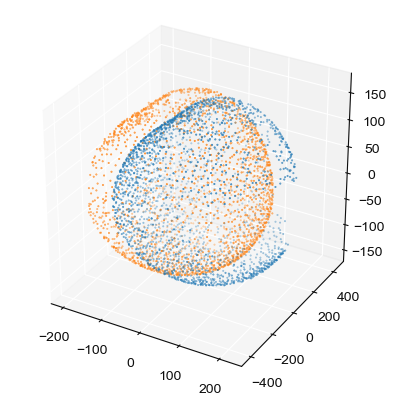

[-3.57716697e-15 -4.11374201e-14  8.94291742e-16]
[2.21602770e-14 1.38501731e-14 1.84668975e-14]
[ 7.18968144e-15  2.87587257e-14 -8.98710180e-16]
[0.00000000e+00 2.87871716e-14 1.52931849e-14]
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)
(2034, 3) (2034, 1)


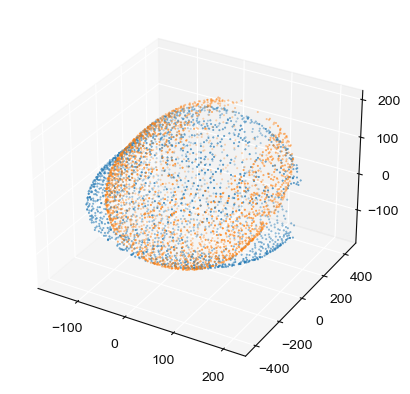

In [96]:
for i, mask in enumerate(masks):
    mask["view"] = i
ct = pd.concat(masks)
# print(ct)
# sns.histplot(ct, x="area", hue="view", bins=100)

ct_filtered = ct[ct["area"].between(100, 1500)]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

for i in range(0, 3, 2):
    df = ct_filtered[ct_filtered["view"] == i]
    pts = df[["centroid-0", "centroid-1", "centroid-2"]].values
    
    centroid = np.mean(pts, axis=0)
    pts -= centroid
    
    pts[:, 0] *= 1/0.525
    
    xz_rot = -np.pi/2 * i * 0

    rot = np.array([[np.cos(xz_rot), 0, -np.sin(xz_rot)],
                    [0, 1, 0],
                    [np.sin(xz_rot), 0, np.cos(xz_rot)]])  
    
    pts = np.dot(pts, rot.T)
    # print(pts.shape)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], label=f"view {i}", s=0.2)
    
    
plt.show()


new_pts = []
    
for i in range(4):
    df = ct_filtered[ct_filtered["view"] == i]
    pts = df[["centroid-0", "centroid-1", "centroid-2"]].values
    centroid = np.mean(pts, axis=0)
    pts -= centroid
    print(pts.mean(axis=0))
    
    pts[:, 0] *= 1/0.525
    
    xz_rot = -np.pi/2 * i // 2 
    rot = np.array([[np.cos(xz_rot), 0, -np.sin(xz_rot)],
                    [0, 1, 0],
                    [np.sin(xz_rot), 0, np.cos(xz_rot)]])
    
    pts = np.dot(pts, rot.T)
    new_pts.append(pts)
    
    
a_new, b_new = icp(new_pts[0], new_pts[2], 25, 10)


plt.figure()
ax = plt.subplot(projection='3d')

for p in [a_new, b_new]:
    ax.scatter(p[:, 0], p[:, 1], p[:, 2], s=0.2)
    
plt.show()

